# Principles of Data Science

### Lecture 14: Goodness of fit tests
_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Goodness of fit tests

- Today's lecture covers 
    - Chi-squared test
    - KS test
- Learning objectives:
    - Understand what goodness of fit tests are, how to use them and how to interpret their results
    - Discuss and critique the pros / cons of different g.o.f tests

## Recap

- Recall from previous lectures
    - Estimation methods: MLE, least-squares, MoM
    - We typically use these to *fit* data in order to *estimate* parameters

## Goodness of fit

- Estimation methods relate to *fitting* datasets
- Often want to understand the *quality* of such fits
- For this we use a *goodness of fit test*

## Test statistics

- A *test statistic* (sometimes just *statistic*) is some value dependent on the **observed data** and **the fitted parameters**

$$ T = f(\theta) $$

- It can be anything we like 
- Ideally it is informative
    - E.g. I could use minutes since birth as a test-statistic for measuring heights in this class (would be a poor choice)
    - Better in that case to use sample estimate of mean heights

- <font color="red">If I know how $T$ is distributed</font> then I can see how this compares to the value of $T$ I see in data


## Test statistics for GoF

- GoF means asking "how well does my data, $X_i$, agree with my fitted model"?
- In this case call the fitted model the *null hypothesis*, $H_0$.
- If I know that $T\sim P(T)$ then I can compute the probability I got this fit or a worse one:

$$ P_{\text{g.o.f}} = \int_{T_0}^{\infty} P(T|H_0) $$

- where $T_0$ is the $T$ evaluated on the data we have

<img src="plots/gof_demo.png" alt="drawing">

## The chi-squared test statistic

- The $\chi^2$ value itself is a great test statisitc in this case
    - Should be distributed as a $\chi^2$ with $k$ degrees of freedom
- We expect on average that $\chi^2 / \text{d.o.f} \approx 1$
- The resulting g.o.f test is called a $\chi^2$ test and the resulting probability is called the $\chi^2$ probability (and sometimes just the $p$-value)

- <font color="blue"> you should be suspicious of fits which result in particularly high or particularly small $p$-values</font>


## How many degrees of freedom?

- For a $\chi^2$ test:
    
$$ n_{\text{d.o.f}} = n_{\text{obs}} - n_{\text{pars}} $$

- $k$ is the **number of observations** (or bins) minus the **number of free parameters**
- Gives a way of *naturally* disadvantaging fits with a high number of parameters
    - e.g. NLL or raw $\chi^2$ will always get smaller with more parameters
    - but $p$-value won't necessarily get larger

## An example fit and $p$-value computation

In [1]:
import numpy as np
np.random.seed(210187)

import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')


In [2]:
from scipy.stats import chi2
from tabulate import tabulate

# define generic polynomial
def p(x, *coeffs):
    ret = 0
    for i, cf in enumerate(coeffs):
        ret = ret + cf*x**i
    return ret

# make some pretend data and add some noise
m_t = lambda x: p(x, 1, -2, 5)
x = np.linspace(0,1,10)
y = m_t(x)
y_e  = 0.2*x**2 + 0.2
y = np.random.normal(y, y_e)

# use numpy to fit with different polynomials
p1 = np.flip( np.polyfit( x, y, w=1/y_e, deg=1 ) )
p2 = np.flip( np.polyfit( x, y, w=1/y_e, deg=2 ) )
p8 = np.flip( np.polyfit( x, y, w=1/y_e, deg=8 ) )

# compute chi2 and p-value for each fit
print_stats = []
for ip in [p1,p2,p8]:
    yp = p(x,*ip)
    c2 = np.sum( (y - yp)**2 / y_e**2 )
    ndof = len(x) - len(ip)
    pv = 1 - chi2.cdf(c2, ndof) if ndof>0 else np.inf
    print_stats.append( [len(ip), ndof, c2, c2/ndof, pv ])

print( tabulate(print_stats, headers=['nPar','nDOF', 'Chi2', 'Chi2/nDOF', 'P-val', '2rtChi2', '2n-1', 'PerDoF', 'P-val']) )


  nPar    nDOF       Chi2    Chi2/nDOF        P-val
------  ------  ---------  -----------  -----------
     2       8  58.4726       7.30907   9.28393e-10
     3       7   4.94718      0.70674   0.666409
     9       1   0.032393     0.032393  0.857168


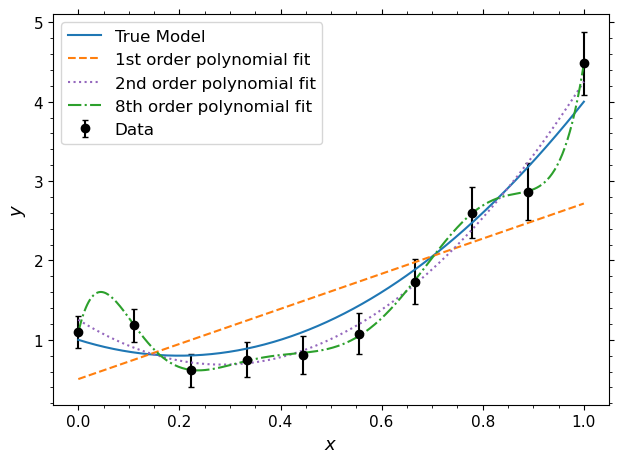

In [3]:
## plot it
plt.errorbar(x, y, y_e, fmt='ko', label="Data")

xp = np.linspace(0,1,400)
plt.plot(xp, m_t(xp), ls='-', label='True Model')
plt.plot(xp, p(xp,*p1), ls='--', label='1st order polynomial fit')
plt.plot(xp, p(xp,*p2), ls=':',  c='C4', label='2nd order polynomial fit')
plt.plot(xp, p(xp,*p8), ls='-.', label='8th order polynomial fit')
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y$', fontsize=13)
plt.legend()

## The power of the chi-squared test

- The $\chi^2$ test is a useful goodness of fit test
- Can get a sense of if the fit is good quality or not
- It can and sometimes is also used as a **hypothesis test**
    - but this is not a great idea
    - it does not have very much statistical power

## Example of $\chi^2$ power

- assume 5 data points with a null hypothesis (flat line), $H_0$
- actually see something a bit different
- compute the $\chi^2$ compatibility 
- also compute the $LL$ with an alternate hypothesis, $H_1$ to show something more powerful.

In [4]:
# 5 bins

# null hypoth
H0 = np.array([1, 1, 1, 1, 1])

# alt hypoth
H1 = np.array([0.8, 1.2, 1.1, 1, 0.9])

# assumed errs
err = np.array([ 0.08, 0.15, 0.15, 0.1, 0.12 ])

# gen data from H1 with assumed errs
np.random.seed(170287)
obs = np.random.normal( H1, err )


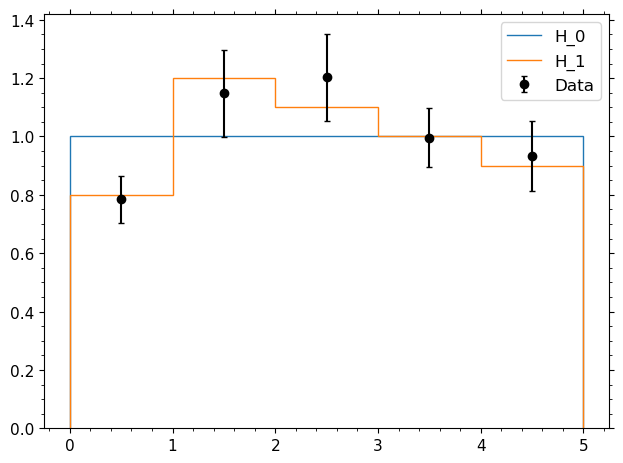

In [5]:
# plot
xp = np.arange(0.5, 5, 1 )
xe = np.arange(0,6)
plt.errorbar( xp, obs, err, fmt='ko', label='Data' )
plt.stairs(H0, xe, label='H_0')
plt.stairs(H1, xe, label='H_1')
plt.legend()

In [6]:
## compute chi^2 g.o.f to flat line
ch2 = np.sum( (obs-H0)**2/err**2 )
ch2_dof = ch2/5
pval = 1 - chi2.cdf(ch2, 5)

print('Chi2:    ', ch2)
print('Chi2/dof:', ch2_dof)
print('p-value: ', pval)


Chi2:     10.35382316337383
Chi2/dof: 2.070764632674766
p-value:  0.06580854833172145


- conclude fit is not particularly good but still less than $2\sigma$ so probably don't claim a new discovery
- compare to LLR

In [7]:
ch2_h1 = np.sum( (obs - H1)**2 / err*2 )
ch2_h1_dof = ch2_h1/5
pval_h1 = 1 - chi2.cdf(ch2_h1, 5)


print('Chi2:    ', ch2_h1)
print('Chi2/dof:', ch2_h1_dof)
print('p-value: ', pval_h1)

delta_chi2 = ch2 - ch2_h1

print('Diff signif', delta_chi2**0.5 )


Chi2:     0.20002652848022823
Chi2/dof: 0.04000530569604564
p-value:  0.9991135756777
Diff signif 3.1865022571612283


- A more powerful hypothesis test rejects $H_0$ in favour of $H_1$ at $> 3\sigma$

# <font color="darkred">*Musical interlude...*</font>

## Residuals and the "pull" distribution

- Visualising fit quality can be done with the `residual` distribution
    - simply plot the difference between data and their prediction
    - how should this be distributed?
    - what is the error on the residual?

In [8]:
# gen data and imagine we have fitted it
from scipy.stats import norm
obs = np.random.normal(size=1000)

In [9]:
# bin the data into histogram
nh, xe = np.histogram(obs, bins=50, range=(-4,4) )

# compare obs to predicted in each bin
N = len(obs)
cx = 0.5*(xe[:-1] + xe[1:])
bw = xe[1:]-xe[:-1]

exp = N*bw*norm.pdf(cx)
resid = nh - exp
err = nh**0.5

<ErrorbarContainer object of 3 artists>

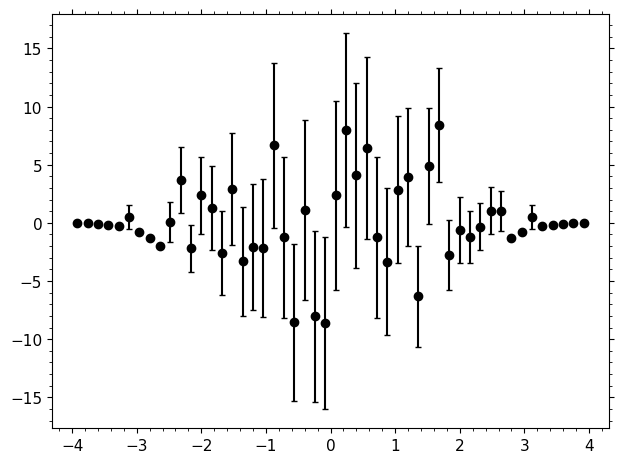

In [10]:
# plot it
plt.errorbar( cx, resid, err, fmt='ko' )

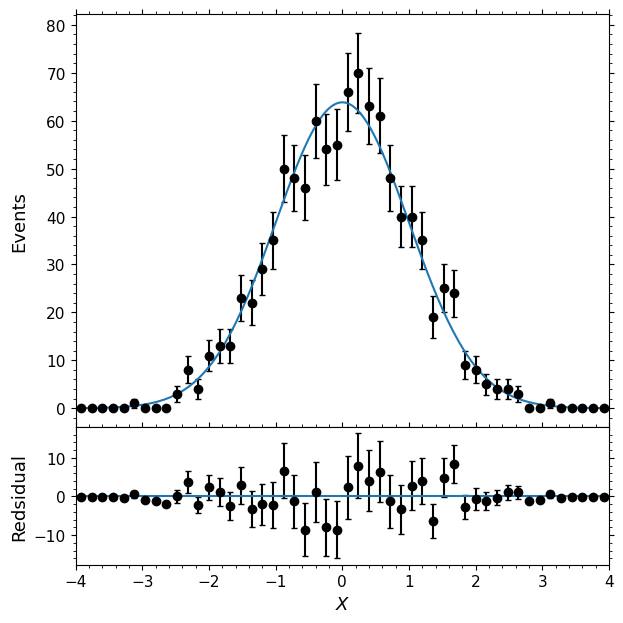

In [11]:
# plot with the original fit
fig, ax = plt.subplots(2, 1, figsize=(6.4,6.4), sharex='col',
    gridspec_kw=dict(hspace=0, height_ratios=(3,1)))

# top figure data points
ax[0].errorbar( cx, nh, nh**0.5, fmt='ko')
# top figure pred line
x = np.linspace(xe[0], xe[-1], 200)
ax[0].plot(x, N*bw[0]*norm.pdf(x) )
ax[0].set_ylabel('Events')

# bottom figure residuals
ax[1].errorbar( cx, resid, nh**0.5, fmt='ko')
# borrom figure flat line
ax[1].plot(x, np.zeros_like(x))
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('Redsidual')

# tight x-axis
ax[0].autoscale(enable=True, tight=True, axis='x')

fig.align_ylabels()

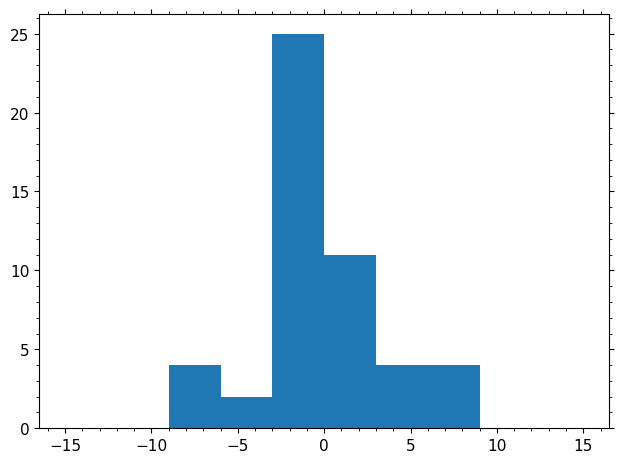

In [12]:
# plot adding the residual distribution itself
_ = plt.hist( resid, bins=10, range=(-15,15) )

## The "pull" distribution

- The pull is the residual normalised by the error

$$ p = (y_{obs} - y_{pred}) / y_{err} $$

- Indicative of the $\chi^2$ which is just the sum of squared pulls
- Bit more informative than the residual
- How should it be distributed?
- What is the error on the pull in each bin?
- Beware of points with no error

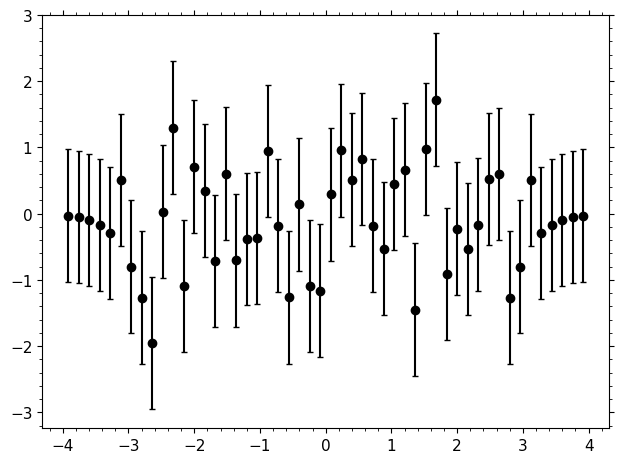

In [13]:
# following from example above
# also plot the a projection of the pull distribution
err[err==0] = 1 
pull = resid / err

_ = plt.errorbar( cx, pull, yerr=1, fmt='ko')

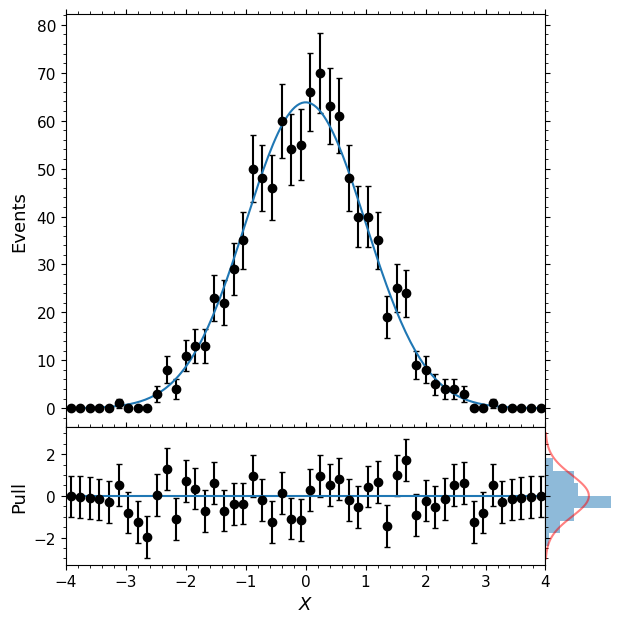

In [14]:
# the fancy version
# plot with the original fit
fig, ax = plt.subplots(2, 2, figsize=(6.4,6.4), sharex='col', sharey='row',
    gridspec_kw=dict(hspace=0, wspace=0, height_ratios=(3,1), width_ratios=(7,1)))

# top figure data points
ax[0,0].errorbar( cx, nh, nh**0.5, fmt='ko')
# top figure pred line
x = np.linspace(xe[0], xe[-1], 200)
ax[0,0].plot(x, N*bw[0]*norm.pdf(x) )
ax[0,0].set_ylabel('Events')

# bottom figure residuals
ax[1,0].errorbar( cx, pull, np.ones_like(cx), fmt='ko')
# borrom figure flat line
ax[1,0].plot(x, np.zeros_like(x))
ax[1,0].set_xlabel('$X$')
ax[1,0].set_ylabel('Pull')

# right figure
ax[0,1].set_visible(False)
ax[1,1].hist(pull, bins=10, range=(-3,3), density=True, alpha=0.5, orientation='horizontal')
ax[1,1].xaxis.set_visible(False)
ax[1,1].spines[['top','bottom','right']].set_visible(False)
ax[1,1].tick_params( which='both', direction='in', axis='y', right=False, labelcolor='none')
xp = np.linspace(-3,3,100)
ax[1,1].plot( norm.pdf(xp), xp, 'r-', alpha=0.5 )

# tight x-axis
ax[0,0].autoscale(enable=True, tight=True, axis='x')

fig.align_ylabels()

- Also good practise to quote $\chi^2$ values on the plots
- Easy to compute from the pull

In [15]:
chisq = np.sum( pull**2 )
ndof  = len(xe) - 1 - 2
pval  = 1 - chi2.cdf(chisq, ndof)


- this turns out to be a very good fit

## The Kolmogorov-Smirnoff (KS) test

 - Sometimes used as an alternative to $\chi^2$ test
 - Useful when you have no underlying distribution
      - e.g. when comparing two datasets
      - comes in handy in machine learning to assess compatibility between e.g. test and training set
 - Determined from the **maximum deviation** between two c.d.f.s:
 
 $$ p_{\text{KS}} = \sqrt{N}  \;\cdot \text{max}( F(X_1) - F(X_2) ) $$
  

## Let's see an example

In [16]:
from scipy.stats import norm, kstest

# generate two datasets from different distributions
np.random.seed(210187)
N = 200
 
dset1 = norm.rvs( loc=0, size=N)
dset2 = norm.rvs( loc=0.5, size=N)

ks1 = kstest( dset1, dset2 )
ks2 = kstest( dset1, 'norm')

In [17]:
from tabulate import tabulate

names = ['D1 vs D2', 'D1 vs Norm']
print_rows = [ [name, ks.statistic, ks.pvalue, ks.statistic_location] for name, ks in zip(names, [ks1,ks2])]

print( tabulate(print_rows, headers=['Name','KS-score','p-value','location']))

Name          KS-score      p-value    location
----------  ----------  -----------  ----------
D1 vs D2     0.255      4.02481e-06    0.132544
D1 vs Norm   0.0500365  0.679394      -0.358556


## Let's make a plot of the two examples

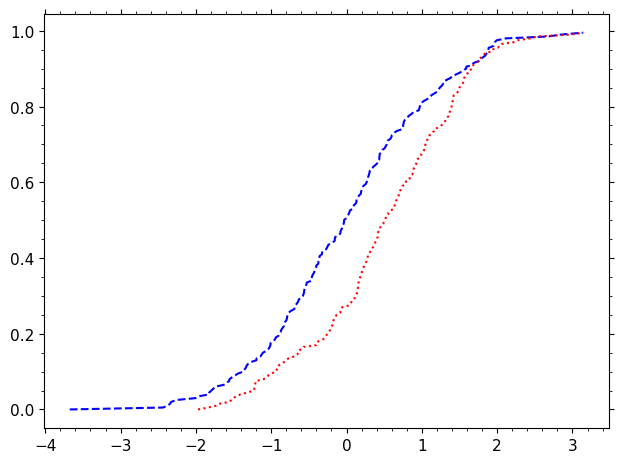

In [18]:
# make the empirical c.d.f of each dataset
dset1 = np.sort(dset1)
dset2 = np.sort(dset2)
  
y = np.arange(N) / float(N)

plt.plot( dset1, y, 'b--')
plt.plot( dset2, y, 'r:') # can swap for norm



### add some more fancy labelling to our plot

Text(-2, 0.675, '$p$-value = 4.02e-06')

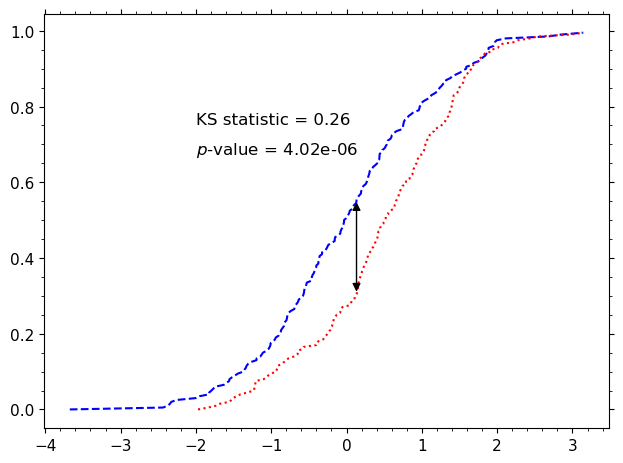

In [19]:
## interpolate between points
from scipy.interpolate import interp1d

f1 = interp1d( dset1, y )
f2 = interp1d( dset2, y )

kst = kstest( dset1, dset2 )
xk  = kst.statistic_location

plt.plot( dset1, y, 'b--') 
plt.plot( dset2, y, 'r:')

# make an arrow
arrowprops = dict(arrowstyle="<|-|>", fc="k")
plt.annotate("", xy=(xk, f1(xk)), xytext=(xk, f2(xk)), arrowprops=arrowprops)
plt.text( -2, f1(xk)+0.2, f"KS statistic = {kst.statistic:4.2f}")
plt.text( -2, f1(xk)+0.12, f"$p$-value = {kst.pvalue:5.3g}", fontsize=12 )


### and compare to something consistent

Text(-2, 0.5799635243682285, '$p$-value = 0.679')

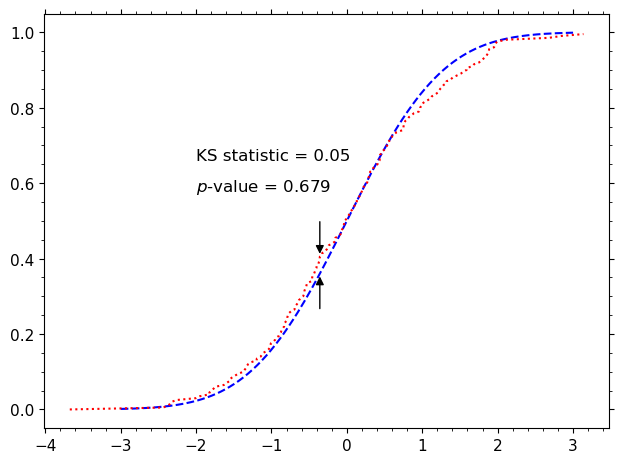

In [20]:
x = np.linspace(-3,3,200)
plt.plot(x, norm.cdf(x), 'b--')
plt.plot( dset1, y, 'r:')

kst = kstest( dset1, 'norm' )
xk  = kst.statistic_location
y1 = norm.cdf(xk)
y2 = f1(xk)

plt.annotate("", xy=(xk, y2), xytext=(xk,y2+0.1), arrowprops=dict(arrowstyle="-|>", fc='k'))
plt.annotate("", xy=(xk, y1), xytext=(xk,y1-0.1), arrowprops=dict(arrowstyle="-|>", fc='k'))

plt.text( -2, y1+0.3, f"KS statistic = {kst.statistic:4.2f}", fontsize=12 )
plt.text( -2, y1+0.22, f"$p$-value = {kst.pvalue:5.3g}", fontsize=12 )

# End of Lecture 14

By the end of this lecture you should:
   - Understand what goodness of fit tests are, how to use them and how to interpret their results
   - Discuss and critique the pros / cons of different g.o.f tests